In [212]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def rotate_box(bb, cx, cy, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def get_patch_image(image, row, col, patch_size):
    patch_image_height = patch_size if image.shape[0] - row > patch_size else image.shape[0] - row
    patch_image_width = patch_size if image.shape[1] - col > patch_size else image.shape[1] - col

    patch_image = image[row: row + patch_image_height, col: col + patch_image_width]
    
    if patch_image_height < patch_size or patch_image_width < patch_size:
        pad_height = patch_size - patch_image_height
        pad_width = patch_size - patch_image_width
        patch_image = np.pad(patch_image, ((0, pad_height), (0, pad_width), (0, 0)), 'constant')
    
    return patch_image

def convert_bbox_to_rbox(cx, cy, h, w, theta):
    x1, y1, x3, y3 = cx-(w/2), cy-(h/2), cx+(w/2), cy+(h/2)
    x4, y4, x2, y2 = cx-(w/2), cy+(h/2), cx+(w/2), cy-(h/2)
    bbox = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
   
    rbox = rotate_box(bbox, cx, cy, -theta)
    return rbox

In [213]:
import os
import pickle
import numpy as np
from skimage.io import imread

import io
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import math
import pandas as pd

import json
info_file = "/content/gdrive/My Drive/findShip/train.pickle" 

with open(info_file, 'rb') as f:
    info = pickle.load(f)

info[2]

{'center_xs': [0.8036823272705078,
  0.7093358039855957,
  0.8217039108276367,
  0.6101360321044922],
 'center_ys': [0.44638538360595703,
  0.496822714805603,
  0.3650566339492798,
  0.6031181812286377],
 'class_indices': [4, 4, 4, 4],
 'class_texts': ['maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels'],
 'col': 1536,
 'heights': [0.04794453829526901,
  0.029971621930599213,
  0.03456564247608185,
  0.038271352648735046],
 'image_filename': '0.png',
 'patch_height': 1024,
 'patch_size': 1024,
 'patch_width': 1024,
 'row': 1536,
 'thetas': [0.04735859419071558,
  0.04735633050378901,
  0.850209450896862,
  0.15207901510064786],
 'widths': [0.23750635981559753,
  0.14870962500572205,
  0.14635401964187622,
  0.14694267511367798]}

In [0]:
src_dir = '/content/gdrive/My Drive/findShip/'
rows = []
classes = {1: 'container', 2: 'oil tanker', 3: 'aircraft carrier', 4: 'maritime vessels'}
image_id = None 

for idx in range(len(info)):
    row = info[idx]['row']
    col = info[idx]['col']
    patch_size = info[idx]['patch_size']

    if not image_id == info[idx]['image_filename']:
        image_id = info[idx]['image_filename']
        image = imread(os.path.join(src_dir, 'images/', image_id))
    patch_image = get_patch_image(image, row, col, patch_size)

    cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
    hs, ws = info[idx]['heights'], info[idx]['widths']
    thetas, labels = info[idx]['thetas'], info[idx]['class_indices']

    imgid = image_id.replace(".png", "")
    patch_filename = F"{imgid}_{row}_{col}.png"
    patch_filepath = os.path.join(src_dir, 'patch_images/', patch_filename)
    
    for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):
        row = []
        (heigth, width) = patch_image.shape[:2]
        (imgcX, imgcY) = (width // 2, heigth // 2)
        theta= math.degrees(theta)

        cy = cy * heigth
        cx = cx * width
        h = h *heigth
        w = w * width

        rbox = convert_bbox_to_rbox(cx, cy, h, w, theta)
        nprbox = np.array(rbox)
        np.where(nprbox < 0, 0, nprbox)
        if heigth == width:
            np.where(nprbox < heigth, heigth, nprbox)

        row.append(patch_filepath)
        row.extend([str(xx) for x in nprbox.tolist() for xx in x])
        row.append(classes[label])
    rows.append(row)


In [161]:
nprbox.tolist()

[[702.6658950028798, 938.8217454193006],
 [945.5997222107299, 950.3353589619071],
 [943.2755112471202, 999.3755202056993],
 [700.3416840392701, 987.8619066630929]]

In [164]:
",".join([str(xx) for x in nprbox.tolist() for xx in x])

'702.6658950028798,938.8217454193006,945.5997222107299,950.3353589619071,943.2755112471202,999.3755202056993,700.3416840392701,987.8619066630929'

In [177]:
rows[3]

['/content/gdrive/My Drive/findShip/patch_images/0_1536_2048.png',
 '504.2040538333828',
 '97.02587896409892',
 '790.4718758627052',
 '92.83739893596302',
 '791.1514149166173',
 '139.28149408277608',
 '504.8835928872948',
 '143.46997411091198',
 'maritime vessels']

In [148]:
len(info), len(rows)

(7603, 7603)

In [151]:
rbox

[(396.77313347885365, 19.974261944902935),
 (652.9940259112336, 613.0125868743792),
 (517.8964221852086, 671.381206805097),
 (261.67552975282865, 78.34288187562075)]

In [0]:
count=0
for idx, row in enumerate(rows):
    filename = row[0].split('/')[-1]
    image_idx = filename.split("_")[0]
    if '0' == image_idx: 
        print(idx)
        image = imread(os.path.join(row[0]))
        print(row[5])
        cv2_imshow(cv2.rectangle(image, (int(row[1]), int(row[2])), (int(row[3]), int(row[4])), (0, 0, 255), 2 ))



In [138]:
','.join([str(r) for r in row])

'/content/gdrive/My Drive/findShip/patch_images/0_1024_1536.png,778.6835966718996,817.8344090585085,904.1660127031003,953.8015772696167,maritime vessels'

In [0]:
import csv

with open('/content/gdrive/My Drive/findShip/train.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for row in rows:
        tg = []
        tg.append(row[0])
        tg.extend( [round(float(i)) for i in row[1:-1]] )
        tg.append(row[-1])
        spamwriter.writerow(tg)    

In [211]:
tg

['/content/gdrive/My Drive/findShip/patch_images/994_2048_2048.png',
 -51,
 26,
 351,
 409,
 252,
 513,
 -150,
 130,
 'maritime vessels']

In [208]:
[round(float(i)) for i in row[1:-1]]

[-51, 26, 351, 409, 252, 513, -150, 130]

In [200]:
a = ['"'+row[0]+'"']
a.extend(row[1:-1])
a.extend(['"'+row[-1]+'"'])
print(a)

['"/content/gdrive/My Drive/findShip/patch_images/994_2048_2048.png"', '-50.823955743380225', '26.369083756810085', '350.67411404330704', '409.4360451310693', '251.51536199338028', '513.3657795244399', '-149.982707793307', '130.2988181501807', '"maritime vessels"']


In [0]:
import csv
with open('/content/gdrive/My Drive/findShip/test.csv', 'w', newline='') as f:
    for row in rows:
        f.write('"')
        f.write('",'.join(row))
        f.write('"')
        f.write('\n')

In [0]:
{1: 'container', 2: 'oil tanker', 3: 'aircraft carrier', 4: 'maritime vessels'}
import csv
with open('/content/gdrive/My Drive/findShip/class.csv', 'w', newline='') as f:
    f.write('container,0')
    f.write('\n')
    f.write('oil tanker,1')
    f.write('\n')
    f.write('aircraft carrier,2')
    f.write('\n')
    f.write('maritime vessels,3')

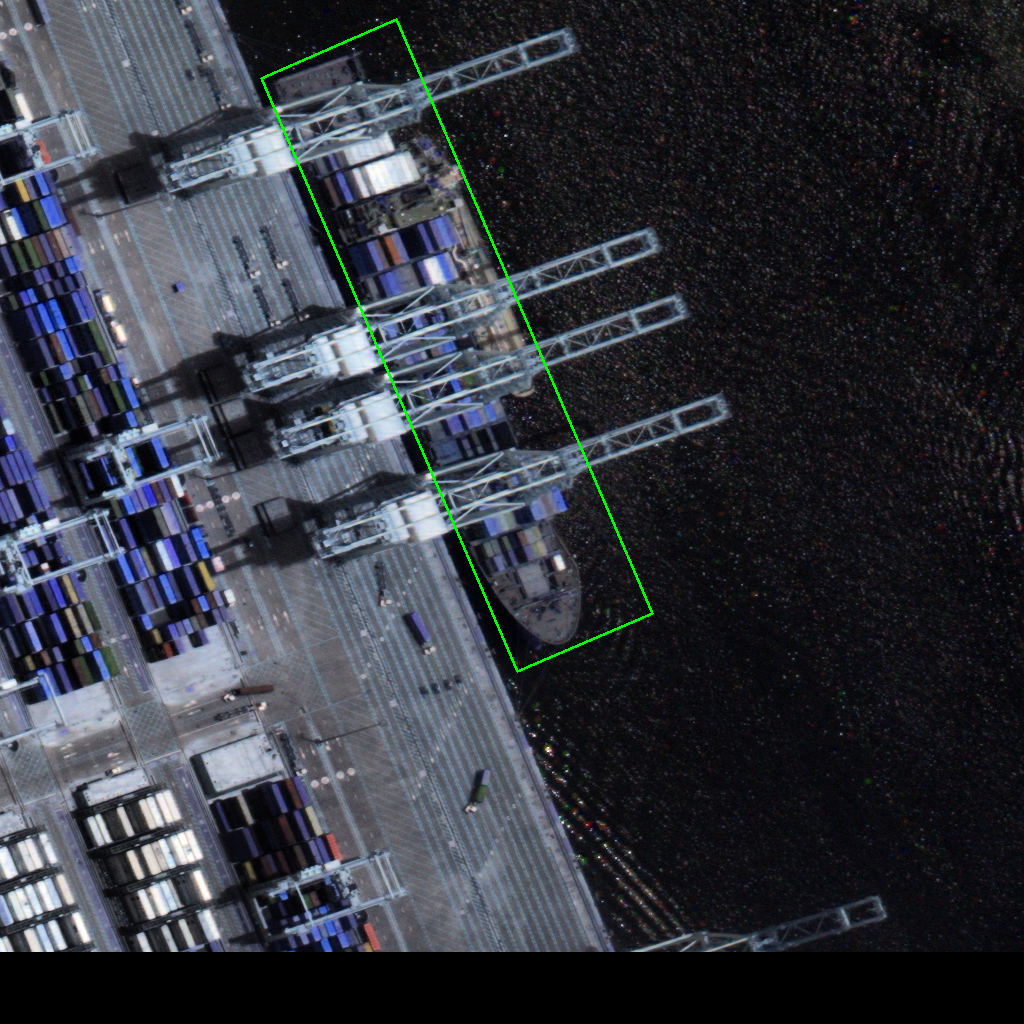

In [173]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

img = cv2.polylines(patch_image, [np.array(rbox, np.int32)], True, (0, 255, 0), 2)  
cv2_imshow(img)

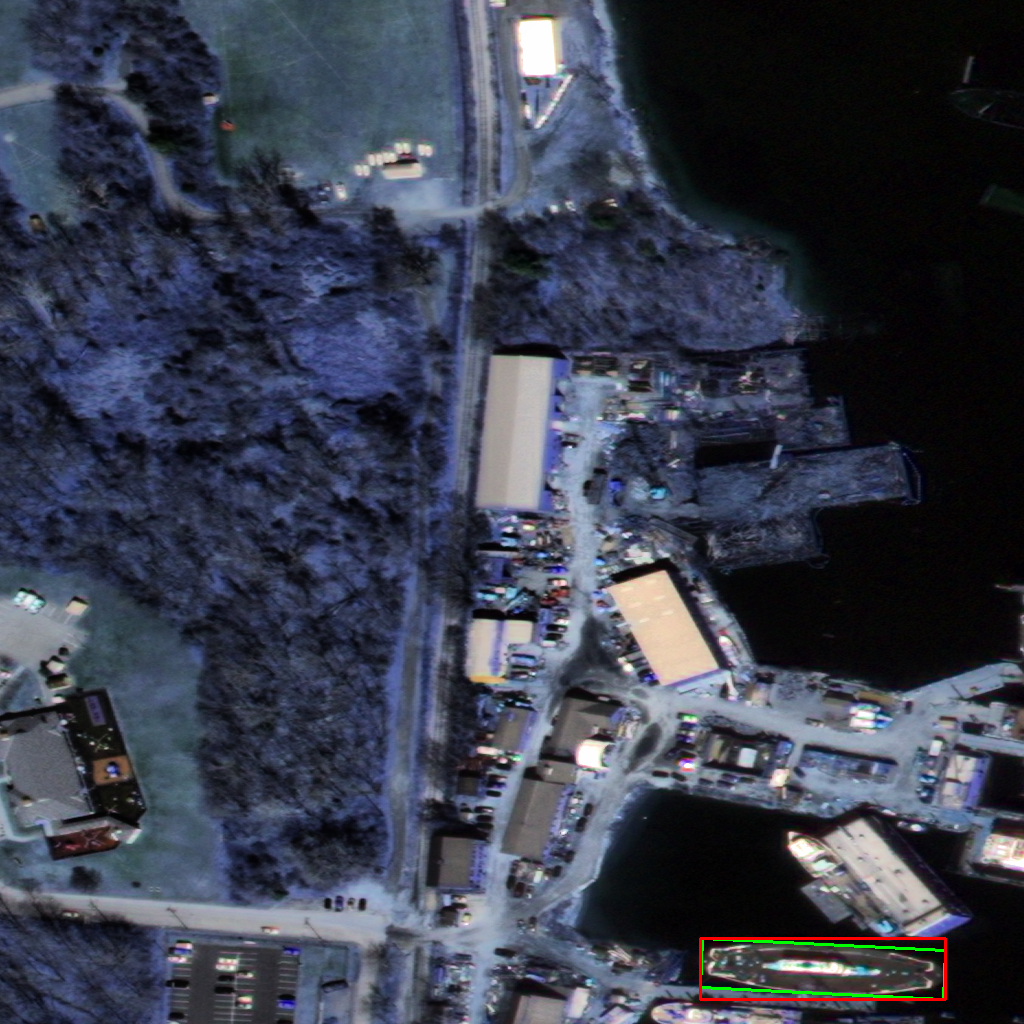

In [65]:

cv2_imshow(cv2.rectangle(patch_image, xyMin, xyMax, (0, 0, 255), 2 ))

In [51]:
xy = pd.DataFrame(data=rbox, columns=['x','y'])

xy1 = xy.nsmallest(2, 'x').nsmallest(1, 'y').values[0].tolist()    
xy2 = xy.nlargest(2, 'y').nlargest(1, 'x').values[0].tolist()  

xy1, xy2

([702.6658950028798, 938.8217454193006],
 [943.2755112471202, 999.3755202056993])

In [62]:
np.array(rbox, np.int32)

array([[702, 938],
       [945, 950],
       [943, 999],
       [700, 987]], dtype=int32)

In [64]:
xs = np.array(rbox, np.int32)[:,0]
ys = np.array(rbox, np.int32)[:,1]
xyMin = min(xs), min(ys)
xyMax = max(xs), max(ys)
xyMin, xyMax

((700, 938), (945, 999))

In [66]:
row, col

(1024, 1536)

In [21]:
    mn = [int(x) for x in xy1]
    mx = [int(x) for x in xy2]

    print("rbbox: ", rbox)
    print("rimage shape: ", rimage.shape)
    print((mn[0], mn[1]), (mx[0], mx[1]))


    cv2.rectangle(rimage, (mn[0], mn[1]), (mx[0], mx[1]), (0, 0, 255), 2 )
    cv2_imshow(rimage)

NameError: ignored

In [0]:
src_dir = '/content/gdrive/My Drive/findShip/'
rows = []
classes = {1: 'container', 2: 'oil tanker', 3: 'aircraft carrier', 4: 'maritime vessels'}
image_id = None 

for idx in range(len(info)):
    row = info[idx]['row']
    col = info[idx]['col']
    patch_size = info[idx]['patch_size']

    if not image_id == info[idx]['image_filename']:
        image_id = info[idx]['image_filename']
        image = imread(os.path.join(src_dir, 'images/', image_id))
    patch_image = get_patch_image(image, row, col, patch_size)

    cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
    hs, ws = info[idx]['heights'], info[idx]['widths']
    thetas, labels = info[idx]['thetas'], info[idx]['class_indices']

    imgid = image_id.replace(".png", "")
    patch_filename = F"{imgid}_{row}_{col}.png"
    patch_filepath = os.path.join(src_dir, 'patch_images/', patch_filename)
    
    for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):
        row = []
        (heigth, width) = patch_image.shape[:2]
        (imgcX, imgcY) = (width // 2, heigth // 2)
        theta= math.degrees(theta)

        cy = cy * heigth
        cx = cx * width
        h = h *heigth
        w = w * width

        rbox = convert_bbox_to_rbox(cx, cy, h, w, theta)
        
        xs = np.array(rbox)[:,0]
        ys = np.array(rbox)[:,1]
        minX, minY = min(xs), min(ys)
        maxX, maxY = max(xs), max(ys)

        if minX <= 0:
            minX = 1
        if width <= maxX:
            maxX = width - 1

        if minY <= 0:
            minY = 1
        if heigth <= maxY:
            maxY = heigth-1
        
        row.append(patch_filepath)
        row.extend([minX, minY])
        row.extend([maxX, maxY])
        row.append(classes[label])
        

    rows.append(row)

In [4]:
src_dir = '/content/gdrive/My Drive/findShip/'
rows = []

for idx in range(len(info)):
    
    image_id = info[idx]['image_filename']
    row = info[idx]['row']
    col = info[idx]['col']
    patch_size = info[idx]['patch_size']

    image = imread(os.path.join(src_dir, 'images/', image_id))
    patch_image = get_patch_image(image, row, col, patch_size)

    cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
    hs, ws = info[idx]['heights'], info[idx]['widths']
    thetas, labels = info[idx]['thetas'], info[idx]['class_indices']

    patch_filename = idx+'_'+row+'_'+col+'.png'
    patch_filepath = os.path.join(src_dir, 'patch_images/', patch_filename)
    
    for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):
        row = []
        (heigth, width) = patch_image.shape[:2]
        (imgcX, imgcY) = (width // 2, heigth // 2)
        theta= math.degrees(theta)

        cy = cy * heigth
        cx = cx * width
        h = h *heigth
        w = w * width

        rbox = convert_bbox_to_rbox(cx, cy, h, w, theta)
        
        xs = np.array(rbox, np.int32)[:,0]
        ys = np.array(rbox, np.int32)[:,1]
        xyMin = min(xs), min(ys)
        xyMax = max(xs), max(ys)
        
        row.append(patch_filepath)
        row.extend([min(xs), min(ys)])
        row.extend([max(xs), max(ys)])
        row.append(label)
        break
    break
        rbbox = rotate_box(rbox, imgcX, imgcY, heigth, width, theta)
        #rimage = rotate_bound(patch_image, theta)

        # 이미지 회전 후 bbox가 이미지 사이즈보다 더 커지는 경우 방지
        # bbox가 이미지 사이즈 보다 크거나 작을 경우 사이즈를 옮긴다
        xs = [box[0] for box in rbbox]
        ys = [box[1] for box in rbbox]

        x_diff = diff_baseline_image(xs, width)
        y_diff = diff_baseline_image(ys, heigth)

        rbbox = [[x+x_diff, y+y_diff] for x, y in zip(xs, ys)]

        xy = pd.DataFrame(data=rbbox, columns=['x','y'])
        xy1 = xy.nsmallest(2, 'x').nsmallest(1, 'y').values[0].tolist()    
        xy2 = xy.nlargest(2, 'y').nlargest(1, 'x').values[0].tolist()  


        if xy1[0] <= 0:
            xy1[0] = 1
        if width <= xy2[0]:
            xy2[0] = width - 1

        if xy1[1] <= 0:
            xy1[1] = 1
        if heigth <= xy2[1]:
            xy2[1] = heigth-1
            
        """
        print(image_features['image/filename'], image.shape) 
        print("rbbox: ", rbbox)
        print("rimage shape: ", image.shape)

        print("xy, xy", xy1, xy2)
        print("image index:", image_idx)
        """
        rbboxs.append(
            {"image_param": {'x_diff': x_diff, 'y_diff': y_diff,
                            'theta': theta, 'fileidx': idx},
            "rbbox": {'minX': xy1[0], 'minY': xy1[1],
                        'maxX': xy2[0], 'maxY': xy2[1],
                        'label': label}
            })
        

{'center_xs': [0.8036823272705078,
  0.7093358039855957,
  0.8217039108276367,
  0.6101360321044922],
 'center_ys': [0.44638538360595703,
  0.496822714805603,
  0.3650566339492798,
  0.6031181812286377],
 'class_indices': [4, 4, 4, 4],
 'class_texts': ['maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels'],
 'col': 1536,
 'heights': [0.04794453829526901,
  0.029971621930599213,
  0.03456564247608185,
  0.038271352648735046],
 'image_filename': '0.png',
 'patch_height': 1024,
 'patch_size': 1024,
 'patch_width': 1024,
 'row': 1536,
 'thetas': [0.04735859419071558,
  0.04735633050378901,
  0.850209450896862,
  0.15207901510064786],
 'widths': [0.23750635981559753,
  0.14870962500572205,
  0.14635401964187622,
  0.14694267511367798]}